## 1. Importaciones y lceturas

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import box

In [11]:
# ee.Authenticate()
ee.Initialize()

In [12]:
useful_crimes = gpd.read_file('filtered dataset/crimes_filtered.shp')
useful_crimes.to_crs('EPSG:4326', inplace=True)

In [13]:
manz = gpd.read_file('nyct2020_23b/nyct2020.shp')
manz.to_crs('EPSG:4326', inplace=True)
manz.head(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."


In [15]:
useful_crimes.head(1)

,cmplnt_num,addr_pct_c,boro_nm,date_cmpln,time_cmpln,cmplnt_fr_,date_cmp_2,time_cmp_2,cmplnt_to_,crm_atpt_c,...,susp_sex,transit_di,vic_age_gr,vic_race,vic_sex,x_coord_cd,y_coord_cd,latitude,longitude,geometry
0,262612530,110.0,QUEENS,2022-09-09,00:00:00.000,00:55:00,2022-09-09,00:00:00.000,01:19:00,COMPLETED,...,M,NaN,25-44,WHITE HISPANIC,F,1019164.0,210169.0,40.743481,-73.874004,POINT (-73.87400 40.74348)


### 1. Importaciones y preprocesamiento

<Axes: >

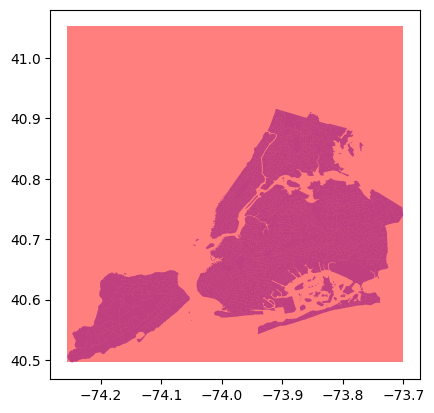

In [16]:
unif = manz.unary_union
bounding_box = unif.bounds
minx, miny, maxx, maxy = bounding_box
width = max(maxx - minx, maxy - miny)
expanded_bbox = box(minx, miny, minx + width, miny + width)
ny_box = gpd.GeoDataFrame(geometry=[expanded_bbox])
ax = manz.plot(color='blue', alpha=0.5)
ny_box.plot(ax=ax, color='red', alpha=0.5)

In [17]:
poly = ny_box.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon([xy[0], xy[1], xy[2], xy[3]])
x = aoi.centroid().getInfo()['coordinates'][0]
y = aoi.centroid().getInfo()['coordinates'][1]

In [18]:
aoi2 = ee.Geometry.Point([x-.1, y-.1])

## 2. Visualización de HeatMaps

In [42]:
def cloudMask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).Or(qa.bitwiseAnd(1 << 4))
    return image.updateMask(mask.Not())

In [47]:
# "LANDSAT/LE07/C01/T1"
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi2).filterDate('2021-01-30', '2023-06-22')
images=collection.aggregate_array('system:id').getInfo()

In [48]:
len(images)

57

In [49]:
def applyScaleFactors(image):
    thermalband = image.multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(srcImg=thermalband, overwrite=True)

In [50]:
Map = geemap.Map()
least_cloudy = ee.Image(collection.sort('CLOUDY_PIXEL_PERCENTAGE').first())
vis_params = {'min': 1,
    'max': 65455, 
    'bands': ['SR_B2', 'SR_B3', 'SR_B4']}

heat_params = {'min': -20,
    'max': 40,
    'bands': 'ST_B10',
    'pallete': ['blue', 'white', 'red']}

clipped_image = least_cloudy.clip(aoi)
image = applyScaleFactors(clipped_image)
Map.addLayer(clipped_image, vis_params, 'Espectro visible')
Map.addLayer(image, heat_params, 'Imagen térmica')
Map.centerObject(aoi2, 10)
Map

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…